## Multi-classification problem


In [ ]:
# Uncomment the next line to install packages
# pip install torch torchvision matplotlib pandas seaborn requests 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import requests
import os


import matplotlib.pyplot as plt

%matplotlib inline

## Load Data

PyTorch provides two powerful data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as prepare your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the Dataset to enable easy access to the samples.

### USPS Dataset
* Handwritten digits with 10 classes
* 16x16 pixels for each image 
* 6 000 data examples in training set, 1 291 examples in validation set, 2 007 in test set

In [2]:
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.bz2'
r = requests.get(url, allow_redirects=True)
if not os.path.isdir('USPS/'):
    os.mkdir('USPS/')
open('USPS/usps.bz2', 'wb').write(r.content)

6579383

In [3]:
# Loading USPS dataset from torchvision.dataset
dataset = torchvision.datasets.USPS(root='USPS/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=False)

In [4]:
# Get info from dataset
dataset

Dataset USPS
    Number of datapoints: 7291
    Root location: USPS/
    StandardTransform
Transform: ToTensor()

In [5]:
# Obtain the inputs and targets:
inputs = dataset.data
targets = dataset.targets

In [6]:
# Let's look at a data point
sample_index = 88

data_sample = dataset.data[sample_index]
target_sample = dataset.targets[sample_index]
print("Sample type and shape : ",type(data_sample),data_sample.shape)
print("Label type and value : " ,type(target_sample),target_sample)

Sample type and shape :  <class 'numpy.ndarray'> (16, 16)
Label type and value :  <class 'int'> 9


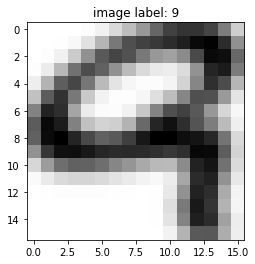

In [7]:
sample_index = 88
plt.imshow(dataset.data[sample_index], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("image label: %d" % dataset.targets[sample_index])
plt.show()

## Pytorch Tensor

Pytorch Documentation : https://pytorch.org/docs/stable/index.html

In [8]:
tensor_data_point = torch.tensor(data_sample)
print("Tensor type :",type(tensor_data_point),", and shape : ",tensor_data_point.shape)

Tensor type : <class 'torch.Tensor'> , and shape :  torch.Size([16, 16])


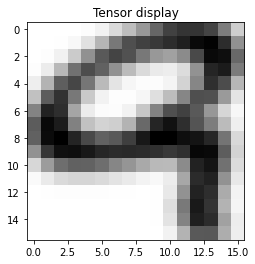

In [9]:
# Pyplot can manage torch Tensors
plt.imshow(tensor_data_point, cmap=plt.cm.gray_r)
plt.title("Tensor display")
plt.show()

In [10]:
# split the dataset to training and validation sets
train_set, val_set = random_split(dataset, [6000, 1291])

## Build your Neural Network
The `torch.nn` namespace provides all the building blocks you need to create your own neural network such as fully connected layers or convolutional layers etc. We define our neural network by subclassing `nn.Module`, and the neural network layers are initialized in **\__init\__**. Every `nn.Module` subclass implements the operations on input data in the **forward** method.

Inheritance in Python (https://www.programiz.com/python-programming/inheritance)

In [11]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, 100)
        self.l2 = nn.Linear(100, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network 
        h = F.relu(self.l1(inputs)) # You can put anything, as long as its Pytorch functions
        outputs = F.softmax(self.l2(h), dim=1)# Use softmax as the activation function for the last layer
        return outputs

Description of AutoGrad (https://pytorch.org/docs/stable/notes/autograd.html)

### Instantiation and forward call

In [12]:
# We initialize the Model class
my_model = Model() # it calls the init method
print(" - What is the type of my_model ?",type(my_model))
print("="*50)
print(" - Description of the internal of the Network :",my_model)
print("="*50)
print(" - Content of the first Layer :", my_model.l1.weight,)

 - What is the type of my_model ? <class '__main__.Model'>
 - Description of the internal of the Network : Model(
  (l1): Linear(in_features=256, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=10, bias=True)
)
 - Content of the first Layer : Parameter containing:
tensor([[-0.0093, -0.0156,  0.0268,  ...,  0.0593, -0.0170, -0.0230],
        [-0.0443, -0.0167, -0.0027,  ..., -0.0157,  0.0386, -0.0597],
        [ 0.0606, -0.0531, -0.0205,  ..., -0.0599, -0.0104,  0.0327],
        ...,
        [-0.0399, -0.0517,  0.0303,  ...,  0.0158,  0.0081,  0.0294],
        [-0.0222, -0.0422, -0.0171,  ...,  0.0497, -0.0345,  0.0518],
        [-0.0609, -0.0579, -0.0337,  ...,  0.0121, -0.0479,  0.0577]],
       requires_grad=True)


In [13]:
# Shape of the Linear Layer 
print("A :",my_model.l1.weight.shape," b : ",my_model.l1.bias.shape)

A : torch.Size([100, 256])  b :  torch.Size([100])


In [14]:
# Let's explore the forward pass
example_batch_size = 3
example_loader = DataLoader(dataset, batch_size=example_batch_size, shuffle=True)

for images,labels in example_loader:
    print("Original tensor shape",images.shape)
    print("="*50)
    print("Impact of the view method",images.view(example_batch_size,-1).shape)
    print("="*50)
    example_output = my_model(images.view(example_batch_size,-1))
    print("Shape of the output",example_output.shape)
    print("="*50)
    print("Predictions for the first image :",example_output[0].detach())
    print("="*50)
    print("Sum of all outputs : ",torch.sum(example_output[0])) # You should use detach !
    break

Original tensor shape torch.Size([3, 1, 16, 16])
Impact of the view method torch.Size([3, 256])
Shape of the output torch.Size([3, 10])
Predictions for the first image : tensor([0.0968, 0.0882, 0.0984, 0.1215, 0.0938, 0.0974, 0.1109, 0.1002, 0.1074,
        0.0855])
Sum of all outputs :  tensor(1.0000, grad_fn=<SumBackward0>)


In [15]:
# Example of One Hot Encoding

labels_one_hot = torch.FloatTensor(example_batch_size, 10)
labels_one_hot.zero_()
print("Original Labels : ",labels.detach())
print("="*50)
print("One Hot encoding :",labels_one_hot.scatter_(1, labels.view(-1, 1), 1).detach())

Original Labels :  tensor([9, 7, 0])
One Hot encoding : tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


## Train your Model

In [16]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Use mean squared loss function 
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [17]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            y_pre = model(images.view(batch_size, -1)) 
            #reshape the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [18]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set)

Epoch [1/10], Loss: 0.0845
Epoch [2/10], Loss: 0.0711
Epoch [3/10], Loss: 0.0579
Epoch [4/10], Loss: 0.0445
Epoch [5/10], Loss: 0.0338
Epoch [6/10], Loss: 0.0261
Epoch [7/10], Loss: 0.0208
Epoch [8/10], Loss: 0.0175
Epoch [9/10], Loss: 0.0155
Epoch [10/10], Loss: 0.0140


Text(0.5, 1.0, 'Visualization of convergence')

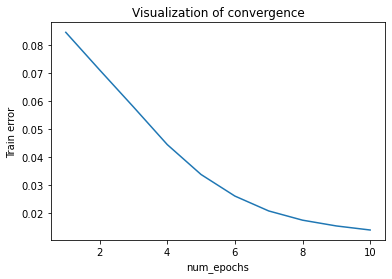

In [19]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

### Evaluate the Model on validation set

In [25]:
# Calculate the accuracy to evaluate the model
def accuracy(dataset, model):

    with torch.no_grad():
        correct = 0
        total = 0
        dataloader = DataLoader(dataset)
        for images, labels in dataloader:
            #images = images.view(-1, 16*16)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  
            correct += (predicted == labels).sum()

    print('Accuracy of the model : {:.2f} %'.format(100*correct.item()/ len(dataset)))

In [23]:
accuracy(val_set, model)

Accuracy of the model : 92.18 %


Text(0.5, 1.0, 'Prediction label: 1')

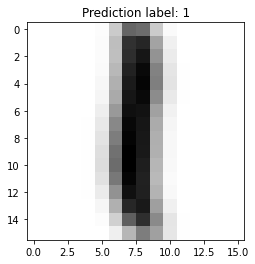

In [24]:
val_index = 66

(image, label) = val_set[val_index]
output = model(image.view(-1, 16*16))
_, prediction = torch.max(output.data, 1)

plt.imshow(image.view(16, 16), cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("Prediction label: %d" % prediction)

### Exercise 1: Impact of the architecture of the model
Define your own class `Model` to improve the predictions:

* The convolutional layer can be a good choice to deal with images. Replace nn.Linear with [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d).
* Try to add more layers (1, 2, 3, more ?)
* Change the number of neurons in hidden layers (5, 10, 20, more ?)
* Try different activation functions such as [sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.

In [41]:
class Model_L1(nn.Module):
    
    def __init__(self):
        super(Model_L1, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Linear(16*16, 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network
        x = self.l1(inputs)
        outputs = F.softmax(x, dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [42]:
class Model_Conv1(nn.Module):
    
    def __init__(self, k):
        super(Model_Conv1, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Conv2d(1,1,kernel_size=k)
        self.l2 = nn.Linear((16 - k + 1) * (16- k + 1), 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network
        x = self.l1(inputs)
        x = F.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.l2(x)
        outputs = F.softmax(x, dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [43]:
class Model_Conv2(nn.Module):
    
    def __init__(self, k, l):
        super(Model_Conv2, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Conv2d(1,1,kernel_size=k)
        self.l2 = nn.Conv2d(1,1,kernel_size=l)
        self.l3 = nn.Linear((16 - k - l + 2) * (16- k - l + 2), 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network
        x = self.l1(inputs)
        x = F.relu(x) # You can put anything, as long as its Pytorch functions
        x = self.l2(x)
        x = F.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.l3(x)
        outputs = F.softmax(x, dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [44]:
class Model_Conv3(nn.Module):
    
    def __init__(self, k, l, m):
        super(Model_Conv3, self).__init__()
        # We allocate space for the weights
        self.l1 = nn.Conv2d(1,1,kernel_size=k)
        self.l2 = nn.Conv2d(1,1,kernel_size=l)
        self.l3 = nn.Conv2d(1,1,kernel_size=m)
        self.l4 = nn.Linear((16 - k - l -m + 3) * (16- k - l -m + 3), 10)
        # Input size is 16*16, output size should be the same with the number of classes
        
    def forward(self, inputs): # Called when we apply the network
        x = self.l1(inputs)
        x = F.relu(x) # You can put anything, as long as its Pytorch functions
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = torch.flatten(x, start_dim=1)
        x = self.l4(x)
        outputs = F.softmax(x, dim=1)# Use softmax as the activation function for the last layer
        return outputs

In [45]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset, dim = 1):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train() # Indicates to the network we are in training mode
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (images, labels) in train_loader:
            
            if dim == 1:
                y_pre = model(images.view(batch_size, -1))
            else:
                y_pre = model(images)
            #reshape - if necessary - the inputs from [N, img_shape, img_shape] to [N, img_shape*img_shape] 
            
            # One-hot encoding or labels so as to calculate MSE error:
            labels_one_hot = torch.FloatTensor(batch_size, 10)
            labels_one_hot.zero_()
            labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
           
            
            loss = criterion(y_pre, labels_one_hot) #Real number
            optimizer.zero_grad() # Set all the parameters gradient to 0
            loss.backward() # Computes  dloss/da for every parameter a which has requires_grad=True
            optimizer.step() # Updates the weights 
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {}'.format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

Epoch [1/10], Loss: 0.0763131102795403
Epoch [2/10], Loss: 0.05494084898692867
Epoch [3/10], Loss: 0.04167352528000872
Epoch [4/10], Loss: 0.03344077732025959
Epoch [5/10], Loss: 0.027987410969411347
Epoch [6/10], Loss: 0.024444318703996652
Epoch [7/10], Loss: 0.022043526906054482
Epoch [8/10], Loss: 0.02032776156828431
Epoch [9/10], Loss: 0.019003411126129008
Epoch [10/10], Loss: 0.017958958167776762
Epoch [1/10], Loss: 0.08981247770289591
Epoch [2/10], Loss: 0.08170648620774348
Epoch [3/10], Loss: 0.04886931308389953
Epoch [4/10], Loss: 0.02184145188308321
Epoch [5/10], Loss: 0.014907343840750405
Epoch [6/10], Loss: 0.012393625454787968
Epoch [7/10], Loss: 0.01111967586318011
Epoch [8/10], Loss: 0.010189443760864385
Epoch [9/10], Loss: 0.009667473238035509
Epoch [10/10], Loss: 0.009155643484918976
Epoch [1/10], Loss: 0.08280876853813729
Epoch [2/10], Loss: 0.05017668856463086
Epoch [3/10], Loss: 0.022211437875715397
Epoch [4/10], Loss: 0.015149687127268415
Epoch [5/10], Loss: 0.01289

Epoch [4/10], Loss: 0.021411001559051006
Epoch [5/10], Loss: 0.014457271758246109
Epoch [6/10], Loss: 0.01234080525629302
Epoch [7/10], Loss: 0.011572755494926333
Epoch [8/10], Loss: 0.010926367254415943
Epoch [9/10], Loss: 0.010333631927025867
Epoch [10/10], Loss: 0.01004348596348489
Epoch [1/10], Loss: 0.09006848548849414
Epoch [2/10], Loss: 0.08988232529411719
Epoch [3/10], Loss: 0.08972854513674972
Epoch [4/10], Loss: 0.08960512839257712
Epoch [5/10], Loss: 0.08950907534609233
Epoch [6/10], Loss: 0.0894364529227218
Epoch [7/10], Loss: 0.0893763665234049
Epoch [8/10], Loss: 0.08606419836481409
Epoch [9/10], Loss: 0.032383421985966124
Epoch [10/10], Loss: 0.017043892502679212
Epoch [1/10], Loss: 0.08873176599542287
Epoch [2/10], Loss: 0.04722436150322509
Epoch [3/10], Loss: 0.016222924586897235
Epoch [4/10], Loss: 0.012921237271691945
Epoch [5/10], Loss: 0.011763750098515015
Epoch [6/10], Loss: 0.011443981035819579
Epoch [7/10], Loss: 0.010474868597516056
Epoch [8/10], Loss: 0.010134

Epoch [9/10], Loss: 0.0892921774337689
Epoch [10/10], Loss: 0.08927901421984025
Epoch [1/10], Loss: 0.08994124545405306
Epoch [2/10], Loss: 0.08978331349790096
Epoch [3/10], Loss: 0.08965199201057351
Epoch [4/10], Loss: 0.08954638487348952
Epoch [5/10], Loss: 0.08946475980182493
Epoch [6/10], Loss: 0.0894035093486309
Epoch [7/10], Loss: 0.0893585228050749
Epoch [8/10], Loss: 0.08932611122727387
Epoch [9/10], Loss: 0.08930328691999102
Epoch [10/10], Loss: 0.08928710444519913
Epoch [1/10], Loss: 0.08943953747550647
Epoch [2/10], Loss: 0.0892984701072176
Epoch [3/10], Loss: 0.08929217851410302
Epoch [4/10], Loss: 0.08929640063395101
Epoch [5/10], Loss: 0.0892900116617481
Epoch [6/10], Loss: 0.08929569881409391
Epoch [7/10], Loss: 0.0892843664934238
Epoch [8/10], Loss: 0.08929273185630641
Epoch [9/10], Loss: 0.08927174627780912
Epoch [10/10], Loss: 0.08928769670426837
Epoch [1/10], Loss: 0.09006043562044706
Epoch [2/10], Loss: 0.0898811709508299
Epoch [3/10], Loss: 0.08973092246800668
Epoc

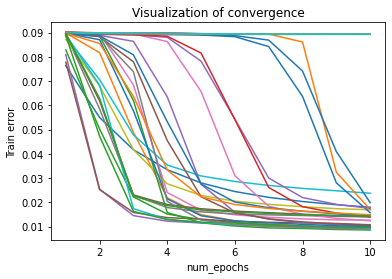

In [46]:
# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

model = Model_L1()
# Use mean squared loss function 
criterion = nn.MSELoss()
# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, 1)
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error, label=f"Modele 1Conv, k={k}")
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

for k in range (1,10):
    # Create the model:
    model = Model_Conv1(k)
    # Use mean squared loss function 
    criterion = nn.MSELoss()
    # Use SGD optimizer with a learning rate of 0.01
    # It is initialized on our model
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)
    # plot the training error wrt. the number of epochs: 
    plt.plot(range(1, num_epochs+1), train_error, label=f"Modele 1Conv, k={k}")
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.title("Visualization of convergence")
    
for k in range (1,5):
    for l in range (1,5):
        # Create the model:
        model = Model_Conv2(k,l)
        # Use mean squared loss function 
        criterion = nn.MSELoss()
        # Use SGD optimizer with a learning rate of 0.01
        # It is initialized on our model
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
        train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)
        # plot the training error wrt. the number of epochs: 
        plt.plot(range(1, num_epochs+1), train_error, label=f"Modele 2Conv, k={k}, l={l}")
        plt.xlabel("num_epochs")
        plt.ylabel("Train error")
        plt.title("Visualization of convergence")
    
for k in range (1,4):
    for l in range (1,4):
        for m in range (1,4):
            # Create the model:
            model = Model_Conv3(k,l,m)
            # Use mean squared loss function 
            criterion = nn.MSELoss()
            # Use SGD optimizer with a learning rate of 0.01
            # It is initialized on our model
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
            train_error = train(num_epochs, batch_size, criterion, optimizer, model, train_set, 2)
            # plot the training error wrt. the number of epochs: 
            plt.plot(range(1, num_epochs+1), train_error, label=f"Modele 3Conv, k={k}, l={l}, m={m}")
            plt.xlabel("num_epochs")
            plt.ylabel("Train error")
            plt.title("Visualization of convergence")
    
plt.show()

In [ ]:
accuracy(val_set, model)

### Exercise 2: Impact of the optimizer
Retrain the model by using different parameters of the optimizer; you can change its parameters in the cell initializing it, after the definition of your model.

* Use different batch sizes, from 10 to 1 000 for instance
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

### Exercise 3: Impact of the loss function
The MSE error is rarely used in this case. The cross entropy loss can be a better choice for multi-classification problems. In pytorch, the cross entropy loss is defined by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss). Replace the MSE loss by this one to observe its impact.

**Note:** In order to use nn.CrossEntropyLoss correctly, don't add an activation function to the last layer of your network. And one-hot encoding is no longer needed to calculate the loss, delete the encoding procedures in function `train`.   

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [ ]:
url = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/usps.t.bz2'
r = requests.get(url, allow_redirects=True)
open('USPS/usps.t.bz2', 'wb').write(r.content)

In [ ]:
# Loading MNIST test set from torchvision.dataset
test_set = torchvision.datasets.USPS(root='USPS/',
                                         train=False,
                                         transform=transforms.ToTensor(),
                                         download=False)

In [ ]:
accuracy(test_set, model)